# Segmentation · Extraction · Behavior — session flow & data layout

This notebook processes one **session** at a time (e.g., a single date/animal/epoch). It aligns behavior and imaging on an **absolute wall-time axis**, extracts ROI fluorescence from motion-corrected movies, and saves a consolidated HDF5 suitable for downstream analysis. It also includes a resumable per-trial cache and an interactive ROI explorer.

---

## Session directory layout

~~~text
/Volumes/MossLab/ImagingData/<YYYYMMDD>/<AnimalID>/<Epoch>/
├── RAW ScanImage TIFFs                    # one stack per trial; names carry a trailing index, e.g., ..._00037.tif
├── Motion-corrected TIFFs (MCOR)          # same stems with "_mcor" suffix, e.g., ..._00037_mcor.tif
├── *_Events.csv                           # behavior event logs; one or more files for the session
├── <session>.h5                           # DAQ/TTL file (5 kHz ImagingWindow TTL used for absolute timing)
├── trace_cache/                           # created by this notebook; per-trial extraction cache
│   ├── <stem>_mcor.npz                    # arrays: F, dFF, Z
│   └── <stem>_mcor.json                   # per-trial metadata
└── <export>.hdf5                            # consolidated output written by this notebook (path = export_hdf5)
~~~


> Notes  
> • MCOR files can live in the session root (as above). If you store them in a subfolder, the `resolved_trial_to_mcor` mapping will still resolve as long as stems match.  
> • Behavior CSVs may be multiple files; the notebook concatenates them into one continuous timeline.

---

## High-level flow

1. **Configure session and build utility functions**: Set `parent_dir`, sampling rate `fr`, behavior column names (`behavior_time_col`, `behavior_event_col`), odor duration (`odor_duration_s`), and match tolerance (`TOL_SECONDS`).

2. **Build pseudo trial video for ROI extraction**: Extract random frames from subset of trial videos during the 1s odor presentation and 1s after odor offset. Compile these into a new tiff stack for feeding into CaImAn CNMF ROI segmentation

3. **Run CaImAn CNMF**: Run CNMF on the pseudotrial video using parameters definied in step 1. Save a resumable copy of variables (pickle) at the end.

4. **Clean ROIs based on morphological parameters**: Filter out large, small, and convoluted perimeter glomeruli with parameters defined in step 1.
    
5. **Read absolute trial timing from the H5**: Parse the 5 kHz **ImagingWindow TTL** to get trial onsets, convert them to **absolute POSIX seconds** (wall time). These become the corrected, ground-truth imaging onsets used downstream. THen, from each RAW TIFF’s metadata, collect its **first-frame POSIX timestamp** and the file **stem**. These are used to pair H5 onsets with real image stacks. To do this, we match each H5 onset to the nearest RAW TIFF first-frame within **± `TOL_SECONDS`**. Store the aligned pairs (stems + times). This establishes the imaging timeline.

6. **Behavior ingestion & trial parse**  
   - Find all `*_Events.csv`, **order** them deterministically (by your chosen rule; e.g., first number in filename), and **concatenate** into a continuous behavior timeline.  
   - Define trial windows and **outcomes** using the window from the first **`Response`** to the subsequent **`Trial Interval`**:  
     - Any **`Reward L/R`** in the window → **Hit**  
     - Else if **Lick L/R count ≥ 3** → **False Choice**  
     - Else → **Miss**

We then build `resolved_trial_to_mcor` by matching trials **by trailing number** in filenames (e.g., `_00037`). Unmapped or missing files are reported and skipped. This includes *Resumable per-trial extraction*
   For each trial in order:
   - If `trace_cache/<stem>_mcor.npz` exists → **load** cached `F`, `dFF`, `Z`.  
   - Else → **load** the MCOR movie, extract traces using the cleaned, session-level ROIs, then **save** to `trace_cache/` (NPZ + JSON).  
   This makes long runs restart-safe and avoids reprocessing.

7. **Consolidated HDF5 export** (`export_hdf5`)  
   Write:
   - **`/trials/<stem>/`**: per-trial datasets (`F`, `dFF`, `Z`).  
   - **`/AlignedBehaviorEvents/`**:  
     - `OdorPresentations` using **H5-corrected onsets** (session-relative seconds)  
     - `Licks`, `Rewards` retimestamped onto the same corrected timeline (and `*_posix` absolutes)  
     - `TrialSummary` table (includes `odor_id`, outcome, corrected start times)  
   - **`/AbsoluteAlignment/`**: the onset vector used (pre/post offset), RAW first-frame times + stems, mapping kind (`trial_to_mcor`), and alignment parameters (e.g., `match_tolerance_s`).

8. **Interactive ROI Explorer**  
   For a selected ROI: show its **footprint** and a **column of subplots (one per odor)**. Individual trial traces are **transparent**, overlaid with **mean traces by outcome** (Hit / False Choice / Miss). Axes share a common y-range for easy comparison, and each subplot lists outcome counts.

---

## Key variables

- `parent_dir` — the session folder (see layout above)  
- `fr` — imaging frame rate (Hz), should be definied from raw tiff metadata
- `odor_duration_s` — seconds, hard coded, but *in the future* can be extracted from session .h5 file  
- `behavior_time_col`, `behavior_event_col` — column names in `*_Events.csv`  
- `TOL_SECONDS` — allowed H5↔RAW alignment tolerance *after applying global offset*  
- `export_hdf5` — full path to the consolidated output



## 1. Environment & Dependencies
- Scientific Python stack: `numpy`, `pandas`, `matplotlib`, `tifffile`, `h5py`, `ipywidgets`, `tqdm`
- **CaImAn** for CNMF (segmentation + cleaning)
- Filesystem times are handled as **POSIX seconds (UTC)**. On macOS we use `st_birthtime`; on Linux we fall back to `st_mtime`.


In [23]:
import os, sys, warnings, json, logging, h5py, re, gc, tempfile, math
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime, timezone, timedelta
from pathlib import Path
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cmm
from matplotlib.lines import Line2D
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from textwrap import shorten, fill



# CaImAn
import caiman as cm
from caiman.source_extraction.cnmf import params as caiman_params
from caiman.source_extraction import cnmf as cnmf_mod
from caiman.cluster import setup_cluster, stop_server
from skimage.measure import regionprops
import scipy.ndimage

plt.rcParams["figure.dpi"] = 120
warnings.filterwarnings("ignore", message=".*nperseg.*", category=UserWarning)
warnings.filterwarnings("ignore", message=".*pkg_resources is deprecated.*", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

## Configure Paths & Core Parameters

**Edit `parent_dir` only.** All other paths derive from it.

Other parameters outside of file paths can be adjusted as needed.

In [11]:
# --- YOU MUST EDIT THIS ---
parent_dir = Path("/Volumes/MossLab/ImagingData/20250912/M169/e1/")
# --- END EDIT ---

# Derived paths
session_dir = parent_dir / "processed"
raw_dir = parent_dir / "raw"
out_dir = session_dir / "outputs"
mcor_dir = session_dir / "mcor"
for p in [out_dir]:
    p.mkdir(exist_ok=True, parents=True)
assert parent_dir.is_dir(), f"Parent directory does not exist: {parent_dir}"
assert mcor_dir.is_dir(), f"Input 'mcor' directory not found at: {mcor_dir}"

# Behavior parsing
behavior_time_col = 'TimeStamp'   # relative per file; code concatenates
behavior_event_col = 'Events'     # e.g., 'Output 1', 'Lick', 'Reward', 'Odor I 3'
odor_duration_s = 1.0

# Imaging / CNMF defaults
num_random_frames_per_trial = 6 # Try to set so that frames * number of videos > 256 (its better if sampling_video has > 256 frames)

fr_manual = 24.0
decay_time = 0.1
dxy = (2, 2)
w10 = 20

# CNMF/cleaning
K = 3; gSig = np.array([w10 // 2, w10 // 2]); gSiz = 2 * gSig + 1
min_SNR = 1.0; rval_thr = 0.3; merge_thr = 0.95
threshold_percentile = 15; convolution_threshold = 50
min_pixels = ((w10) ** 2) / 3; max_pixels = ((w10) ** 2) * 6

# Export paths
export_hdf5 = out_dir / "batch_analysis_results.hdf5"
sampling_movie_path = out_dir / "sampling_movie_for_segmentation.tif"
summary_fig_A = out_dir / "summary_corr_max_overlays.png"

print("Parent directory:", parent_dir.resolve())
print("Outputs:", out_dir.resolve())

Parent directory: /Volumes/MossLab/ImagingData/20250912/M169/e1
Outputs: /Volumes/MossLab/ImagingData/20250912/M169/e1/processed/outputs


## Utilities
1. Filesystem Times & Helpers
2. Ground‑Truth Absolute Timeline (from `.h5`)
    - Locate the single `.h5` in `parent_dir`
    - Set **`h5_start_time_wall`** to filesystem birth time (or mtime fallback)
    - Read **ImagingWindow TTL** and parse **rising edges** at **5 kHz**
    - Convert onsets to **absolute** timestamps by adding anchor time
3. Timing helpers
    - Get actual timestamps from raw tiffs
    - Align to h5 trial onsets
    - Map trials to motion corrected videos
4. Concatenate and parse behavioral data
    - Order behavior files
    - Concatenate all `*_Events.csv` into a single timeline and then compute **trial outcomes** between the first `Response` and the subsequent `Trial Interval`:
        - If any `Reward R` or `Reward L` occurs in the window → **Hit**  
        - Else if `Lick L` + `Lick R` count ≥ 3 → **False Choice**  
        - Else → **Miss**
4. CNMF helpers
5. Helpers for building and saving master output `h5` 

In [3]:
def get_birth_or_mtime_seconds(path: Path) -> float:
    """Return filesystem creation time if available, else mtime, as POSIX seconds (UTC)."""
    st = path.stat()
    t = getattr(st, 'st_birthtime', None)
    if t is None:
        t = st.st_mtime
    return float(t)


def as_utc_datetime(ts_seconds: float) -> datetime:
    return datetime.fromtimestamp(ts_seconds, tz=timezone.utc)

In [4]:
def _get_birth_or_mtime_seconds(path: Path) -> float:
    st = path.stat()
    return float(getattr(st, "st_birthtime", st.st_mtime))

def _as_utc(ts_seconds: float) -> datetime:
    return datetime.fromtimestamp(ts_seconds, tz=timezone.utc)

def _find_single_h5(parent_dir: Path) -> Path:
    h5s = list(parent_dir.glob("*.h5"))
    if len(h5s) != 1:
        raise FileNotFoundError(f"Expected exactly one .h5 in {parent_dir}, found {len(h5s)}")
    return h5s[0]

def _find_imagingwindow_dataset(h5f: h5py.File) -> str:
    hits = []
    def _cb(name, obj):
        if isinstance(obj, h5py.Dataset) and "imagingwindow" in name.lower():
            hits.append(name)
    h5f.visititems(_cb)
    if not hits:
        raise KeyError("Could not find a dataset containing 'ImagingWindow' in the .h5")
    return hits[0]

def _percentile_threshold(x: np.ndarray, q_low: float, q_high: float, frac: float) -> float:
    lo = float(np.percentile(x, q_low))
    hi = float(np.percentile(x, q_high))
    if not np.isfinite(hi - lo) or hi <= lo:
        lo, hi = float(np.min(x)), float(np.max(x))
    return lo + float(frac) * (hi - lo)

def build_ground_truth_trial_onsets(
    parent_dir: Path,
    fs_hz: float = 5000.0,
    dataset_hint: str | None = None,   # e.g., "Acquisition/ImagingWindow"
    # Rising-edge policy
    min_low_s: float = 5.0,            # require ≥ this much time since last kept edge
    debounce_ms: float = 10.0,         # ignore edges within this many ms of the previous raw edge
    # Threshold policy on RAW signal (fixed polarity: HIGH when ttl >= thr)
    threshold_method: str = "percentile",  # "percentile" | "manual"
    q_low: float = 1.0, q_high: float = 99.99, thr_frac: float = 0.50,
    manual_threshold: float | None = None
):
    """
    Returns:
        h5_path (Path),
        h5_start_time_wall (UTC datetime),
        trial_onsets_wall_posix (np.ndarray of float POSIX seconds)
    """
    # 0) Anchor
    h5_path = _find_single_h5(parent_dir)
    anchor_posix = _get_birth_or_mtime_seconds(h5_path)
    h5_start_time_wall = _as_utc(anchor_posix)

    # 1) Load raw TTL
    with h5py.File(h5_path, "r") as f:
        ds_path = dataset_hint if dataset_hint else _find_imagingwindow_dataset(f)
        ttl = np.asarray(f[ds_path], dtype=float).ravel()
        if ttl.ndim != 1 or ttl.size < 3:
            raise ValueError(f"'ImagingWindow' dataset must be a 1D TTL-like trace. Got shape {ttl.shape}")

    # 2) Threshold (fixed polarity)
    if threshold_method == "manual" and (manual_threshold is not None):
        thr = float(manual_threshold)
        thr_info = f"manual thr={thr:.6g}"
    else:
        thr = _percentile_threshold(ttl, q_low=q_low, q_high=q_high, frac=thr_frac)
        thr_info = f"percentile p{q_low}/{q_high} frac {thr_frac:.2f} → thr={thr:.6g}"

    high = ttl >= thr

    # 3) Rising edges on raw thresholded signal (low→high)
    rising_idx = np.flatnonzero(~high[:-1] & high[1:]) + 1
    n_raw_edges = int(rising_idx.size)

    # Optional small debounce to collapse any double-detects from noisy shoulders
    if n_raw_edges:
        min_sep = max(1, int(round((debounce_ms / 1000.0) * fs_hz)))
        kept = [int(rising_idx[0])]
        for idx in rising_idx[1:]:
            if idx - kept[-1] >= min_sep:
                kept.append(int(idx))
        rising_idx = np.asarray(kept, dtype=int)

    # 4) Keep first edge then require ≥ min_low_s gap to keep the next (greedy)
    if rising_idx.size == 0:
        rel_onsets_s = np.array([], dtype=float)
    else:
        gap_samples = int(round(min_low_s * fs_hz))
        kept = [int(rising_idx[0])]
        for idx in rising_idx[1:]:
            if idx - kept[-1] >= gap_samples:
                kept.append(int(idx))
        rel_onsets_s = np.asarray(kept, dtype=float) / float(fs_hz)

    # 5) Absolute wall time
    trial_onsets_wall_posix = anchor_posix + rel_onsets_s

    # Diagnostics
    iti = np.diff(rel_onsets_s) if rel_onsets_s.size > 1 else np.array([])
    print(f"[Ground Truth] .h5: {h5_path.name}")
    print(f"[Ground Truth] Using '{ds_path}' (fs={fs_hz} Hz)")
    print(f"[Ground Truth] {thr_info}")
    print(f"[Ground Truth] rising edges (raw): {n_raw_edges}  → after debounce: {len(trial_onsets_wall_posix)} (before gap filter: {rising_idx.size})")
    print(f"[Ground Truth] min_low_s (gap keep rule): {min_low_s:.2f}s  | debounce={debounce_ms:.1f}ms")
    print(f"[Ground Truth] Trials kept: {len(trial_onsets_wall_posix)}")
    if iti.size:
        print(f"[Ground Truth] ITI (s): mean={iti.mean():.2f}, median={np.median(iti):.2f}, "
              f"min={iti.min():.2f}, max={iti.max():.2f}")
    print(f"[Ground Truth] h5_start_time_wall (UTC): {h5_start_time_wall.isoformat()}")

    return h5_path, h5_start_time_wall, trial_onsets_wall_posix


In [5]:
# -------- Config --------
DEFAULT_LOCAL_TZ = "America/Los_Angeles"  # set to your acquisition timezone

# -------- Basics --------
def get_valid_tiff_files(directory: Path):
    """List *.tif/*.tiff (excluding '._' files), sorted by name."""
    all_files = sorted(list(directory.glob("*.tif")) + list(directory.glob("*.tiff")))
    return [f for f in all_files if not f.name.startswith("._")]

def _file_birth_or_mtime_seconds(p: Path) -> float:
    st = p.stat()
    t = getattr(st, "st_birthtime", None)
    if t is None:
        t = st.st_mtime
    return float(t)

# -------- ScanImage ImageDescription parsing --------
_RE_EPOCH = re.compile(
    r"epoch\s*=\s*\[\s*(\d{4})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})\s+([\d\.]+)\s*\]",
    re.IGNORECASE
)
def _re_float_field(name: str):
    return re.compile(rf"{name}\s*=\s*([\-+]?\d+(?:\.\d+)?)", re.IGNORECASE)

_RE_FRAME_TS = _re_float_field("frameTimestamps_sec")
_RE_ACQ_TRIG = _re_float_field("acqTriggerTimestamps_sec")

def _first_frame_wall_time_from_desc(tif_path: Path, local_tz: str = DEFAULT_LOCAL_TZ) -> float | None:
    """
    First-frame POSIX UTC seconds using:
      epoch (LOCAL) + frameTimestamps_sec  [preferred]
      epoch (LOCAL) + acqTriggerTimestamps_sec  [fallback]
    Returns None if required fields are missing.
    """
    with tifffile.TiffFile(tif_path) as tf:
        desc = getattr(tf.pages[0], "description", "") or ""
    m_epoch = _RE_EPOCH.search(desc)
    if not m_epoch:
        return None

    Y, M, D, h, m, s_float = m_epoch.groups()
    Y, M, D, h, m = map(int, (Y, M, D, h, m))
    s_float = float(s_float)

    # Build timezone-aware local epoch, then add relative seconds
    epoch_local = pd.Timestamp(year=Y, month=M, day=D, hour=h, minute=m, second=0, tz=local_tz)
    epoch_local = epoch_local + pd.to_timedelta(s_float, unit="s")

    m_frame = _RE_FRAME_TS.search(desc)
    m_trig  = _RE_ACQ_TRIG.search(desc)
    if m_frame:
        rel = float(m_frame.group(1))
    elif m_trig:
        rel = float(m_trig.group(1))
    else:
        return None

    first_local = epoch_local + pd.to_timedelta(rel, unit="s")
    first_utc = first_local.tz_convert("UTC")
    return float(first_utc.value / 1e9)

# -------- List RAW TIFF first-frame times --------
def list_tiff_onsets_raw(
    raw_dir: Path,
    local_tz: str = DEFAULT_LOCAL_TZ,
    fallback_filesystem: bool = True,
    verbose_every: int = 0,
):
    """
    Returns a time-sorted list of (filename_stem, first_frame_posix_utc_seconds).

    Primary source: ScanImage ImageDescription
      - epoch = [YYYY M D h m s.sss]   (LOCAL time base)
      - frameTimestamps_sec            (preferred)
      - acqTriggerTimestamps_sec       (fallback)
    Optional fallback: filesystem birth/mtime if metadata missing.
    """
    tiffs = get_valid_tiff_files(raw_dir)
    if not tiffs:
        raise FileNotFoundError(f"No TIFFs in raw_dir: {raw_dir}")

    records: list[tuple[str, float]] = []
    missing_meta = 0

    for i, p in enumerate(tiffs):
        t0 = _first_frame_wall_time_from_desc(p, local_tz=local_tz)
        if t0 is None:
            missing_meta += 1
            if fallback_filesystem:
                t0 = _file_birth_or_mtime_seconds(p)
            else:
                # skip files with no usable metadata if no fallback
                continue
        records.append((p.stem, float(t0)))
        if verbose_every and (i % verbose_every == 0):
            print(f"[RAW] {p.name}: {pd.to_datetime(t0, unit='s', utc=True).isoformat()}")

    records.sort(key=lambda x: x[1])
    print(f"[RAW] extracted first-frame times for {len(records)} raw TIFFs "
          f"(metadata missing on {missing_meta}{' — used file-time fallback' if fallback_filesystem and missing_meta else ''})")
    return records

# -------- Stems → MCOR paths --------
def map_stem_to_mcor_path(mcor_dir: Path):
    """Map filename stem → full motion-corrected TIFF path."""
    return {p.stem: p for p in get_valid_tiff_files(mcor_dir)}

# -------- Offset, mapping, diagnostics --------
def compute_coarse_offset_first(
    ground_truth_onsets_posix: np.ndarray,
    raw_onsets_records: list[tuple[str, float]]
) -> float:
    """
    Coarse offset to align H5 → RAW, using first items only:
      offset_s = first_raw_first_frame - first_h5_onset
    Add this offset to all H5 onsets before matching.
    """
    if len(raw_onsets_records) == 0:
        raise ValueError("raw_onsets_records is empty.")
    if ground_truth_onsets_posix is None or len(ground_truth_onsets_posix) == 0:
        raise ValueError("ground_truth_onsets_posix is empty.")
    first_raw_t = float(raw_onsets_records[0][1])
    first_h5_t  = float(ground_truth_onsets_posix[0])
    return first_raw_t - first_h5_t

def shift_onsets(onsets_posix: np.ndarray, offset_s: float) -> np.ndarray:
    """Return a shifted copy of onsets: onsets' = onsets + offset_s."""
    a = np.asarray(onsets_posix, dtype=float)
    return a + float(offset_s)

def build_trial_to_filename_map_monotonic(
    gt_onsets_posix: np.ndarray,
    raw_onsets_records: list[tuple[str, float]],
    tolerance_s: float
) -> dict[int, str]:
    """
    Greedy, left→right, one-to-one nearest mapping with tolerance.
    Returns {trial_index: raw_stem}.
    """
    stems = [s for s, _ in raw_onsets_records]
    times = np.array([t for _, t in raw_onsets_records], dtype=float)
    mapping: dict[int, str] = {}
    j = 0
    for i, gt in enumerate(np.asarray(gt_onsets_posix, dtype=float)):
        # advance while the next is closer
        while j + 1 < len(times) and abs(times[j + 1] - gt) <= abs(times[j] - gt):
            j += 1
        if j < len(times) and abs(times[j] - gt) <= tolerance_s:
            mapping[i] = stems[j]
            j += 1  # consume this raw entry to keep one-to-one
    return mapping

def print_alignment_diagnostics(
    mapping: dict[int, str],
    raw_onsets_records: list[tuple[str, float]],
    used_gt_onsets_posix: np.ndarray,
    max_examples: int = 10
):
    """
    Print Δt stats (RAW − H5') for the accepted matches and show a few examples.
    """
    if not mapping:
        print("[Align] No matches to report.")
        return
    raw_times = dict(raw_onsets_records)
    deltas_ms = np.array([(raw_times[stem] - float(used_gt_onsets_posix[i])) * 1000.0
                          for i, stem in mapping.items()], dtype=float)
    print(f"[Align] {len(mapping)} matches | Δt (ms): "
          f"median={np.median(deltas_ms):+.1f}, mean={np.mean(deltas_ms):+.1f}, "
          f"min={np.min(deltas_ms):+.1f}, max={np.max(deltas_ms):+.1f}")
    for k, (i, stem) in enumerate(list(mapping.items())[:max_examples]):
        t_raw = raw_times[stem]
        t_gt  = float(used_gt_onsets_posix[i])
        print(f"  trial {i:3d}  RAW={datetime.fromtimestamp(t_raw, tz=timezone.utc).isoformat()}  "
              f"H5'={datetime.fromtimestamp(t_gt,  tz=timezone.utc).isoformat()}  "
              f"Δ={(t_raw - t_gt)*1000:+.1f} ms")


In [6]:

def build_trial_to_filename_map(gt_onsets_wall_sec: np.ndarray,
                                raw_onsets: list[tuple[str, float]],
                                tolerance_s: float = 2.0) -> dict[int, str]:
    if len(gt_onsets_wall_sec) == 0 or len(raw_onsets) == 0:
        return {}
    raw_times = np.array([t for (_, t) in raw_onsets], dtype=float)
    mapping = {}
    for i, t_gt in enumerate(gt_onsets_wall_sec):
        j = int(np.argmin(np.abs(raw_times - t_gt)))
        dt = abs(raw_times[j] - t_gt)
        if dt <= tolerance_s:
            mapping[i] = raw_onsets[j][0]
    print(f"[Align] Mapped {len(mapping)} / {len(gt_onsets_wall_sec)} trials (tol={tolerance_s}s)")
    return mapping


# MCOR resolution by trailing number only

def extract_trailing_number(stem: str) -> tuple[str | None, int | None]:
    """
    Extract the final numeric token from a filename stem, allowing a trailing `_mcor`.
    Examples:
      '20250822_sid174_e1_00037'        -> ('00037', 37)
      '20250822_sid174_e1_00037_mcor'   -> ('00037', 37)
    Returns (string_token, int_value) or (None, None) if no number found.
    """
    # strip an optional trailing '_mcor'
    s = re.sub(r'(_mcor)$', '', stem, flags=re.IGNORECASE)
    # take the numeric token at the end (after removing _mcor)
    m = re.search(r'(\d+)$', s)
    if not m:
        # fallback: take the last numeric block anywhere
        m = re.search(r'(\d+)(?!.*\d)', s)
        if not m:
            return None, None
    tok = m.group(1)
    try:
        return tok, int(tok)
    except Exception:
        return tok, None

def map_trailing_number_to_mcor_path(mcor_dir: Path, prefer_shortest_name: bool = True) -> dict:
    """
    Build an index from trailing number -> MCOR path.
    Keys include both the zero-padded string and the integer:
      idx['00037'] -> Path(...)
      idx[37]      -> Path(...)
    If multiple files map to the same number, choose the shortest filename.
    """
    idx: dict[object, Path] = {}
    for p in get_valid_tiff_files(mcor_dir):
        tok, num = extract_trailing_number(p.stem)
        if tok is None:
            continue
        for key in (tok, num):
            if key is None:
                continue
            if key not in idx:
                idx[key] = p
            elif prefer_shortest_name and len(p.name) < len(idx[key].name):
                idx[key] = p
    return idx

def resolve_mcor_for_trials_by_number(trial_to_stem: dict[int, str], mcor_dir: Path):
    """
    Resolve each aligned RAW stem to an MCOR file using ONLY the number token.
    Returns (resolved_map, unresolved_list).
    """
    idx = map_trailing_number_to_mcor_path(mcor_dir)
    resolved: dict[int, Path] = {}
    unresolved: list[tuple[int, str]] = []
    for i, raw_stem in trial_to_stem.items():
        tok, num = extract_trailing_number(raw_stem)  # RAW stems already end with the number
        p = idx.get(tok) or idx.get(num)
        if p is None:
            unresolved.append((i, raw_stem))
        else:
            resolved[i] = p
    return resolved, unresolved



In [15]:

def find_behavior_files(parent_dir: Path):
    print("--- Searching for behavioral event files ---")
    behavior_dirs = list(parent_dir.glob('????_??_??-??_??_??'))
    if not behavior_dirs:
        raise FileNotFoundError(f"No date-stamped behavior directory in {parent_dir}")
    behavior_base_dir = behavior_dirs[0]
    print(f"  - Found behavior directory: {behavior_base_dir.name}")
    protocol_dirs = sorted([d for d in behavior_base_dir.iterdir() if d.is_dir()])
    all_events_csvs = []
    for protocol_dir in protocol_dirs:
        events_in_protocol = sorted(list(protocol_dir.glob('*Events.csv')))
        all_events_csvs.extend(events_in_protocol)
    if not all_events_csvs:
        raise FileNotFoundError(f"No '*Events.csv' files in {behavior_base_dir}")
    print(f"  - Found and sorted {len(all_events_csvs)} Events CSV files across {len(protocol_dirs)} protocols.")
    return {'events_csvs': all_events_csvs}

_protocol_dt_suffix_re = re.compile(
    r'(?:[-_ ]?)\d{4}[-_]\d{2}[-_]\d{2}[-_]\d{2}[-_:]\d{2}[-_:]\d{2}$',
    re.IGNORECASE
)

def protocol_from_events_filename(p: Path) -> str:
    """
    Return the leading part of an Events filename, without the trailing
    'date-time-Events.csv'. Examples:
      TaskA-2025_09_16-14_03_22-Events.csv -> 'TaskA'
      GoNoGo_v2-2025-09-16-14_03_22-Events.csv -> 'GoNoGo_v2'
    """
    name = p.name
    if name.lower().endswith('-events.csv'):
        base = name[:-len('-Events.csv')]
    else:
        base = p.stem  # fallback (shouldn’t happen with given glob)
    base = _protocol_dt_suffix_re.sub('', base)
    # strip any trailing separators left behind
    return base.rstrip('-_ ')


def _parse_trial_slice(trial_df, event_col, time_col):
    odor_event_series = trial_df[trial_df[event_col].str.startswith('Odor', na=False)]
    odor_id = -1
    if not odor_event_series.empty:
        odor_event_string = odor_event_series[event_col].iloc[0]
        match = re.search(r'Odor I (\d+)', odor_event_string)
        if match:
            odor_id = int(match.group(1))
    lick_events = trial_df[trial_df[event_col] == 'Lick']
    reward_events = trial_df[trial_df[event_col] == 'Reward']
    outcome = 'Miss'
    if not reward_events.empty:
        reward_value = str(reward_events.get('Value', pd.Series([""])).iloc[0]).lower()
        if 'r' in reward_value: outcome = 'Reward R'
        elif 'l' in reward_value: outcome = 'Reward L'
        else: outcome = 'Reward'
    elif not lick_events.empty:
        outcome = 'FC'
    return {'odor_id': odor_id, 'outcome': outcome}


def process_and_concatenate_events(events_csv_files, odor_duration, time_col, event_col):
    """
    Outcome logic:
      - Define window = [first 'Response', first 'Trial Interval' after it (or trial end)]
      - If any 'Reward R' or 'Reward L' in window  -> 'Hit'
      - Else if count('Lick L' + 'Lick R') >= 3    -> 'False Choice'
      - Else                                        -> 'Miss'
    """
    print("--- Concatenating and processing all behavioral events ---")
    processed_dfs = []
    cumulative_time_offset = 0.0

    # 1) Read and stitch timelines into a single continuous stream
    for file_path in events_csv_files:
        df = pd.read_csv(file_path, header=1)
        if time_col not in df.columns:
            raise KeyError(f"Time column '{time_col}' not found in {Path(file_path).name}. Headers: {list(df.columns)}")
        if event_col not in df.columns:
            raise KeyError(f"Event column '{event_col}' not found in {Path(file_path).name}. Headers: {list(df.columns)}")

        df[time_col] = pd.to_numeric(df[time_col], errors='coerce').fillna(0.0)
        proto = protocol_from_events_filename(Path(file_path))
        df['behavioral_protocol'] = proto
        df[time_col] += cumulative_time_offset
        processed_dfs.append(df)

        # next file starts after this one’s max time
        cumulative_time_offset = float(df[time_col].max())

    master_events_df = pd.concat(processed_dfs, ignore_index=True)
    print(f"  - Continuous timeline length: {cumulative_time_offset:.2f}s")

    # 2) Split into trials by odor onset marker ('Output 1')
    trial_starts = master_events_df[master_events_df[event_col] == 'Output 1']
    trial_summary_list = []

    # Classify outcome using window [Response, Trial Interval)
    def classify_outcome(trial_df, start_time, end_time):
        # Find first Response in this trial
        resp_rows = trial_df[trial_df[event_col] == 'Response']
        if resp_rows.empty:
            # No response window -> cannot be Hit; treat as Miss (no/too-few licks by definition)
            return "Miss"

        response_t = float(resp_rows.iloc[0][time_col])

        # Window ends at first Trial Interval after Response, else trial end
        ti_after_resp = trial_df[(trial_df[time_col] > response_t) & (trial_df[event_col] == 'Trial Interval')]
        window_end = float(ti_after_resp.iloc[0][time_col]) if not ti_after_resp.empty else end_time

        win = trial_df[(trial_df[time_col] >= response_t) & (trial_df[time_col] < window_end)]

        # Reward?
        if win[event_col].isin(['Reward R', 'Reward L']).any():
            return "Hit"

        # Licks?
        lick_count = int(win[event_col].isin(['Lick R', 'Lick L']).sum())
        if lick_count >= 3:
            return "False Choice"
        else:
            return "Miss"

    # 3) Build per-trial summary rows
    for i in range(len(trial_starts)):
        start_time = float(trial_starts.iloc[i][time_col])
        end_time = float(trial_starts.iloc[i+1][time_col]) if i + 1 < len(trial_starts) else float(master_events_df[time_col].max())

        trial_df = master_events_df[
            (master_events_df[time_col] >= start_time) & (master_events_df[time_col] < end_time)
        ]

        parsed_info = _parse_trial_slice(trial_df, event_col, time_col)  # expects keys 'odor_id', maybe old 'outcome'

        # Override outcome according to the new rules
        outcome = classify_outcome(trial_df, start_time, end_time)
        proto_val = trial_df['behavioral_protocol'].iloc[0] if 'behavioral_protocol' in trial_df.columns and not trial_df.empty else None

        trial_summary_list.append({
            'trial_index'    : i,
            'trial_start_time': start_time,
            'odor_id'        : parsed_info.get('odor_id', None),
            'outcome'        : outcome,
            'trial_end_time' : end_time,
            'behavioral_protocol' : proto_val,
        })

    trial_summary_df = pd.DataFrame(trial_summary_list)
    print(f"  - Parsed {len(trial_summary_df)} trials.")
    return master_events_df, trial_summary_df


In [8]:

def get_scanimage_fps(movie_path, default_fr=None):
    try:
        with tifffile.TiffFile(movie_path) as tif:
            if not hasattr(tif, 'scanimage_metadata'):
                return default_fr
            si_meta = tif.scanimage_metadata
            possible_keys = ['SI.hRoiManager.scanFrameRate', 'SI.hScan2D.scanFrameRate', 'hScan2D.scanFrameRate']
            frame_data = si_meta.get('FrameData', {})
            for key in possible_keys:
                if key in frame_data:
                    print(f"Inferred frame rate from raw scanimage tiffs. fr = {float(frame_data[key])}")
                    return float(frame_data[key])
            print(f"No fr keys found in scanimage metadata. Defaulting to manual frame rate.")        
            return default_fr
            

    except Exception:
        print(f"No scanimage tiffs found. Defaulting to manual frame rate.")
        return default_fr


def create_sampling_movie(mcor_dir: Path, output_path: Path, num_frames_per_trial: int, fr: float):
    all_frames = []
    trial_files_list = get_valid_tiff_files(mcor_dir)
    trial_files = trial_files_list[::3]
    if not trial_files:
        raise FileNotFoundError(f"No valid TIFF files found in {mcor_dir}")
    print(f"Found {len(trial_files)} trial videos. Sampling frames from 5-7s window...")
    for trial_path in tqdm(trial_files, desc="Sampling trials"):
        with tifffile.TiffFile(trial_path) as tif:
            num_total_frames = len(tif.series[0].pages)
            start_frame, end_frame = int(5.0 * fr), int(7.0 * fr)
            end_frame = min(end_frame, num_total_frames)
            if start_frame >= end_frame:
                continue
            valid_indices_pool = np.arange(start_frame, end_frame)
            num_to_sample = min(num_frames_per_trial, len(valid_indices_pool))
            if num_to_sample == 0:
                continue
            frame_indices = np.random.choice(valid_indices_pool, size=num_to_sample, replace=False)
            all_frames.append(tif.asarray(key=frame_indices))
    if not all_frames:
        raise ValueError("No frames were sampled. Check if videos are shorter than 7s.")
    sampling_movie = np.concatenate(all_frames, axis=0)
    tifffile.imwrite(output_path, sampling_movie)
    print(f"Saved sampling movie with {sampling_movie.shape[0]} frames to: {output_path}")
    return output_path, sampling_movie


def build_cnmf_params(movie_path_str, frame_rate, dxy_tuple):
    rf_target, stride_target = int(w10 + 2), int(2 * w10 / 3)
    opts_dict = {
        "data": {"fnames": [movie_path_str], "fr": float(frame_rate), "dxy": tuple(map(float, dxy_tuple))},
        "decay_time": decay_time,
        "patch": {"rf": rf_target, "stride": stride_target, "only_init": False},
        "init": {"K": int(K), "gSig": [int(gSig[0]), int(gSig[1])], "gSiz": [int(gSiz[0]), int(gSiz[1])], "ssub": 1, "tsub": 1},
        "merging": {"merge_thr": merge_thr},
        "quality": {"min_SNR": float(min_SNR), "rval_thr": float(rval_thr)}
    }
    return caiman_params.CNMFParams(params_dict=opts_dict)


def fit_cnmf(images, params, n_processes=1, dview=None):
    info = {"used_fit_file": True, "did_refit": False, "delta_C_rms": None}
    print("  - Converting sampling movie to CaImAn's memmap format...")
    caiman_mmap_path = cm.save_memmap([images], base_name='caiman_refit_movie_', order='C')
    model = cnmf_mod.CNMF(n_processes=n_processes, params=params, dview=dview)
    model.fit_file(caiman_mmap_path)
    print(f"[CNMF] Components after initial fit: {model.estimates.A.shape[1]}")
    C_before = np.array(model.estimates.C, copy=True)
    try:
        print("  - Refitting components...")
        images_for_refit = cm.load(caiman_mmap_path)
        images2 = np.array(images_for_refit, dtype=np.float32, order="F", copy=True)
        np.nan_to_num(images2, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        cnmf_refit = model.refit(images2)
        info["did_refit"] = True
        C_after = np.array(cnmf_refit.estimates.C, copy=True)
        if C_before.shape == C_after.shape:
            diff = C_after - C_before
            rms = float(np.sqrt(np.mean(diff**2)))
            info["delta_C_rms"] = rms
            print(f"  - Refit ΔC RMS: {rms:.6g}")
        print(f"[CNMF] Components after refit: {cnmf_refit.estimates.A.shape[1]}")
        return cnmf_refit, info
    except Exception as e:
        print(f"WARNING: refit failed: {e}. Proceeding with un-refit components.")
        return model, info


def clean_components(fit, **kwargs):
    d1, d2 = fit.dims
    A_full = fit.estimates.A.toarray().reshape((d1, d2, -1), order="F")
    kept_indices, contours = [], {'valid':[], 'large':[], 'small':[], 'convoluted':[]}
    for k in range(A_full.shape[2]):
        comp = A_full[:, :, k]
        binary = comp > (kwargs['threshold_percentile'] / 100.0) * comp.max()
        labeled, n = scipy.ndimage.label(binary)
        if n == 0:
            continue
        mask = (labeled == (np.argmax(np.bincount(labeled.flat)[1:]) + 1))
        mask = scipy.ndimage.binary_fill_holes(mask)
        area = mask.sum()
        if area == 0:
            continue
        props = regionprops(mask.astype(int))[0]
        edge = scipy.ndimage.binary_dilation(mask) ^ mask
        if (props.perimeter ** 2) / props.area > kwargs['convolution_threshold']:
            contours['convoluted'].append(edge); continue
        if area > kwargs['max_pixels']:
            contours['large'].append(edge); continue
        if area < kwargs['min_pixels']:
            contours['small'].append(edge); continue
        kept_indices.append(k); contours['valid'].append(edge)
    A_cleaned_flat = [fit.estimates.A.toarray()[:, k] for k in kept_indices]
    print(f"Cleaned components: kept={len(contours['valid'])}, small={len(contours['small'])}, large={len(contours['large'])}, convoluted={len(contours['convoluted'])}")
    return {'kept_indices': kept_indices, 'cleaned_A_list': A_cleaned_flat, 'contours': contours}


def build_pixel_dataframe(fit, kept_indices):
    d1, d2 = fit.dims
    pixel_records = []
    A_csr = fit.estimates.A.tocsr()
    for comp_id in kept_indices:
        col = A_csr[:, comp_id].tocoo()
        if col.nnz == 0: continue
        pix_idx, w_raw = col.row, col.data.astype(float)
        w_norm = w_raw / (w_raw.sum() + 1e-10)
        y, x = (pix_idx % d1).astype(int), (pix_idx // d1).astype(int)
        pixel_records.append(pd.DataFrame({"ROI": comp_id, "pixel_idx": pix_idx, "y": y, "x": x, "weight_raw": w_raw, "weight_norm": w_norm}))
    return pd.concat(pixel_records, ignore_index=True) if pixel_records else pd.DataFrame()


def extract_traces_for_trial(trial_movie, cleaned_A_list, dims, fr):
    T, (d1, d2) = trial_movie.shape[0], dims
    A_cleaned = csr_matrix(np.stack(cleaned_A_list, axis=1))
    Yr = trial_movie.reshape((T, -1), order="F").T
    F_weighted = A_cleaned.T @ Yr
    mean_F = F_weighted.mean(axis=1, keepdims=True)
    std_F = F_weighted.std(axis=1, keepdims=True); std_F[std_F == 0] = 1
    Z_traces = (F_weighted - mean_F) / std_F
    win = min(1000, 2 * (T // 10) + 1)
    F0 = pd.DataFrame(F_weighted.T).rolling(win, center=True, min_periods=1).quantile(0.08).to_numpy().T
    dFF_traces = (F_weighted - F0) / np.maximum(F0, 1e-6)
    return np.asarray(F_weighted), np.asarray(dFF_traces), np.asarray(Z_traces)

## 2. Create Sampling Movie

Infer frame rate from a RAW TIFF if possible, otherwise use `fr_manual`. Build the sampling movie from **MCOR** videos by extracting n random frames from the period during and immediately after the odor presentation. Change slicing in the mcor file list variable to chnge subset of trials used. More trials used takes much longer to load but gives a better sampling of activity patterns across an experiment. Right now the slicing is hard coded to every third file in the experiemntal/processed/mcor directory.

Inferred frame rate from raw scanimage tiffs. fr = 25.0729790173987
Found 44 trial videos. Sampling frames from 5-7s window...


Sampling trials:   0%|          | 0/44 [00:00<?, ?it/s]

Saved sampling movie with 264 frames to: /Volumes/MossLab/ImagingData/20250912/M169/e1/processed/outputs/sampling_movie_for_segmentation.tif
--- Pre-computing QC images ---


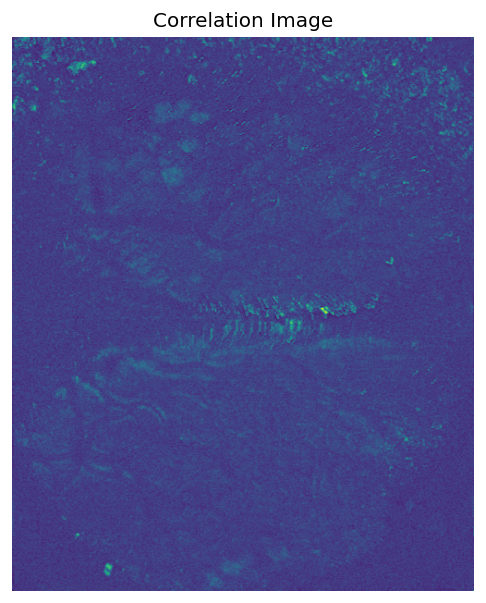

In [9]:
# Infer frame rate from RAW TIFF metadata (ScanImage) if available
fr_probe = None
raw_probe_files = get_valid_tiff_files(raw_dir)
if raw_probe_files:
    fr_probe = get_scanimage_fps(raw_probe_files[0], default_fr=fr_manual)
fr = fr_probe if fr_probe else fr_manual

sampling_movie_path, sampling_movie = create_sampling_movie(mcor_dir, sampling_movie_path, num_random_frames_per_trial, fr)

# Precompute QC images
print("--- Pre-computing QC images ---")
max_proj_img = np.max(np.nan_to_num(sampling_movie), axis=0)
corr_img = cm.local_correlations(sampling_movie, swap_dim=False)
np.save(out_dir / "qc_max_projection.npy", max_proj_img)
np.save(out_dir / "qc_correlation_image.npy", corr_img)
plt.figure(figsize=(6,6)); plt.imshow(corr_img, cmap='viridis'); plt.title('Correlation Image'); plt.axis('off'); plt.show()



## 3. Run CNMF

Runs an inital fitting on patches. If n frames in the sampling video are < 256, it will throw a ton of warnings you can ignore. After initial fitting it runs a refit on the whole video. After the refit, a backup state is saved so that we can resume post fitting. 

In [10]:
# CNMF
params = build_cnmf_params(str(sampling_movie_path), fr, dxy)
dview = None
try:
    c, dview, n_processes = setup_cluster(backend='multiprocessing')
    print(f"[CNMF] Cluster with {n_processes} procs")
except Exception as e:
    print(f"Cluster start failed, using single process: {e}")
    n_processes = 1

fit, fit_info = fit_cnmf(sampling_movie, params, n_processes=n_processes, dview=dview)
if dview is not None:
    stop_server(dview=dview)
    print("[CNMF] Cluster stopped.")

# Backup state (lightweight)
import pickle
backup_path = out_dir / "caiman_fit_backup.pkl"
with open(backup_path, 'wb') as f:
    pickle.dump({'fit': fit, 'fit_info': fit_info, 'fr': fr, 'out_dir': out_dir, 'parent_dir': parent_dir,
                 'odor_duration_s': odor_duration_s, 'behavior_time_col': behavior_time_col, 'behavior_event_col': behavior_event_col}, f)
print("Saved CNMF state to", backup_path)

del sampling_movie; gc.collect()

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


[CNMF] Cluster with 7 procs
  - Converting sampling movie to CaImAn's memmap format...


Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. S

[CNMF] Components after initial fit: 819
  - Refitting components...


/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],


[CNMF] Components after refit: 817
[CNMF] Cluster stopped.
Saved CNMF state to /Volumes/MossLab/ImagingData/20250912/M169/e1/processed/outputs/caiman_fit_backup.pkl


0

## 4. Clean Components & QC Figures

Morphological/shape filters classify components. 

Two QC/diagnostic plots are saved to the output folder: 
1. correlation image with kept ROI contours
2. Max‑projection with kept and rejected ROI contours overlaid and color coded by rejection reason

Cleaned components: kept=247, small=434, large=0, convoluted=136
--- Kept ROI Pixel Info (head) ---


,ROI,pixel_idx,y,x,weight_raw,weight_norm
0,41,73870,70,123,0.016406,0.001015
1,41,74464,64,124,0.008920,0.000552
2,41,74469,69,124,0.012721,0.000787
3,41,74470,70,124,0.049614,0.003069
4,41,74471,71,124,0.012451,0.000770


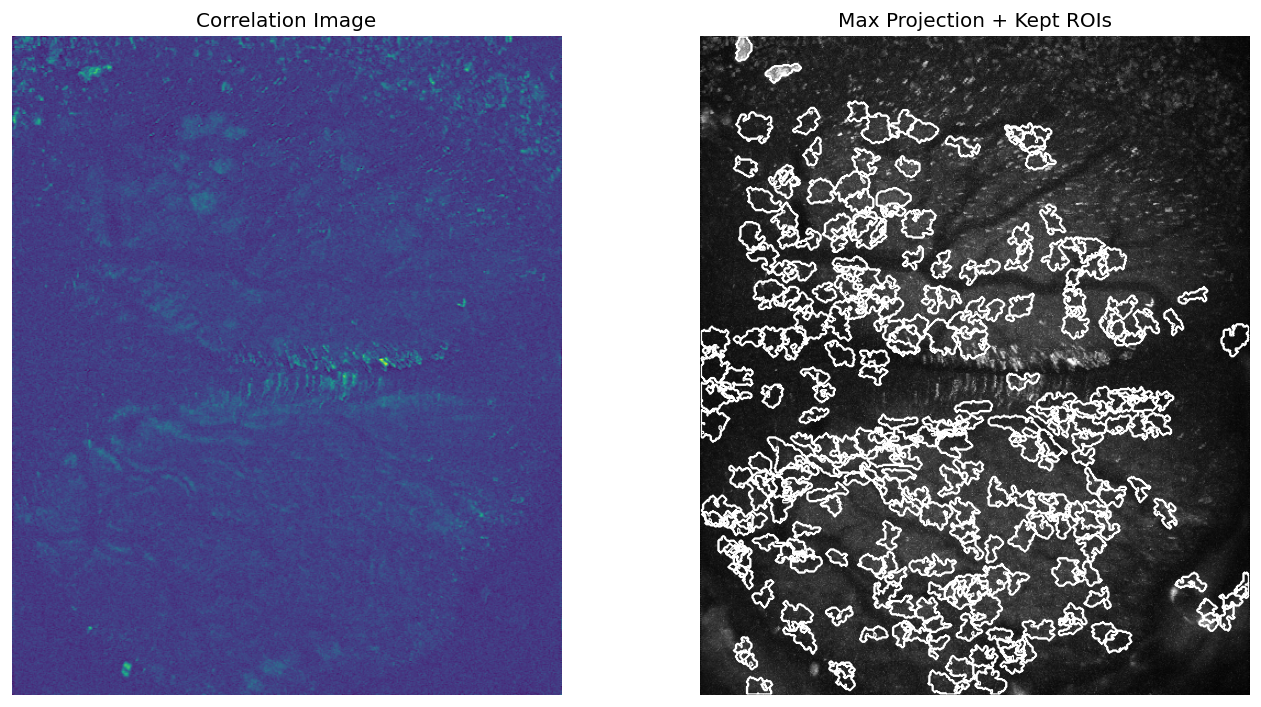

Saved: /Volumes/MossLab/ImagingData/20250912/M169/e1/processed/outputs/summary_corr_max_overlays.png


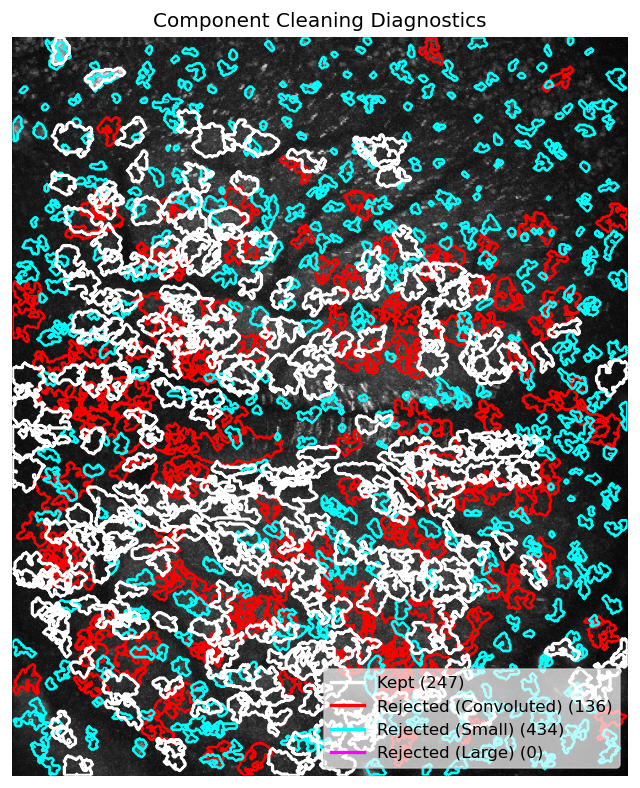

Saved: /Volumes/MossLab/ImagingData/20250912/M169/e1/processed/outputs/summary_overlay_all_classes.png


In [12]:
cleaning_params = {
    'threshold_percentile': threshold_percentile,
    'min_pixels': min_pixels,
    'max_pixels': max_pixels,
    'convolution_threshold': convolution_threshold
}
clean_results = clean_components(fit, **cleaning_params)
kept_indices = clean_results['kept_indices']
cleaned_A_list = clean_results['cleaned_A_list']
df_pixels = build_pixel_dataframe(fit, kept_indices)
print("--- Kept ROI Pixel Info (head) ---")
display(df_pixels.head())

# Summary Figure A
max_proj = np.load(out_dir / "qc_max_projection.npy")
corr_img = np.load(out_dir / "qc_correlation_image.npy")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(corr_img, cmap='viridis'); ax1.set_title('Correlation Image'); ax1.axis('off')
ax2.imshow(max_proj, cmap='gray'); ax2.set_title('Max Projection + Kept ROIs'); ax2.axis('off')
for contour in clean_results['contours']['valid']:
    ax2.contour(contour, colors='white', linewidths=0.75)
fig.tight_layout(); fig.savefig(summary_fig_A); plt.show()
print("Saved:", summary_fig_A)

# Detailed overlay
from matplotlib.lines import Line2D
fig_detail, ax_detail = plt.subplots(figsize=(8,8))
ax_detail.imshow(max_proj, cmap='gray')

def _draw(ax, edges, color, lw):
    for e in edges:
        ax.contour(e.astype(float), levels=[0.5], colors=color, linewidths=lw)

_draw(ax_detail, clean_results['contours']['convoluted'], 'red', 0.9)
_draw(ax_detail, clean_results['contours']['small'], 'cyan', 0.9)
_draw(ax_detail, clean_results['contours']['large'], 'magenta', 0.9)
_draw(ax_detail, clean_results['contours']['valid'], 'white', 1.2)
legend_elements = [
    Line2D([0],[0], color='white', lw=2, label=f"Kept ({len(clean_results['contours']['valid'])})"),
    Line2D([0],[0], color='red', lw=2, label=f"Rejected (Convoluted) ({len(clean_results['contours']['convoluted'])})"),
    Line2D([0],[0], color='cyan', lw=2, label=f"Rejected (Small) ({len(clean_results['contours']['small'])})"),
    Line2D([0],[0], color='magenta', lw=2, label=f"Rejected (Large) ({len(clean_results['contours']['large'])})"),
]
ax_detail.legend(handles=legend_elements, loc='lower right', frameon=True, framealpha=0.7)
ax_detail.set_title('Component Cleaning Diagnostics'); ax_detail.axis('off')
out_overlay_path = out_dir / "summary_overlay_all_classes.png"
fig_detail.savefig(out_overlay_path, dpi=250, bbox_inches='tight'); plt.show()
print("Saved:", out_overlay_path)

## 5. Aligning behvioral trials to correct mcor tiffs

- **Step 1**: derive `ground_truth_trial_onsets` from `.h5`
- **Step 2**: extract RAW TIFF creation times
- **Step 3**: nearest‑neighbor match with tolerance (default `±250 ms`)
- **Step 4**: map trials to corresponding **mcor** tiffs 

In [16]:
# ---- Step 1: ground-truth onsets from H5 (unchanged) ----
TTL_FS_HZ = 5000.0

h5_path, h5_start_time_wall, ground_truth_trial_onsets = build_ground_truth_trial_onsets(
    parent_dir,
    fs_hz=TTL_FS_HZ,
    dataset_hint=None,        # or exact HDF5 dataset path
    min_low_s=5.0,            # require 5 s quiet before a trial onset
    threshold_method="percentile",
    q_low=1.0, q_high=99.99, thr_frac=0.50,
    manual_threshold=None
)

print(f"[GT] .h5 file: {h5_path.name}")
print(f"[GT] anchor (UTC): {h5_start_time_wall.isoformat()}")
print(f"[GT] onsets found: {len(ground_truth_trial_onsets)}")
if len(ground_truth_trial_onsets):
    print("First few onsets (UTC):")
    for s in [
        datetime.fromtimestamp(float(t), tz=timezone.utc).isoformat()
        for t in ground_truth_trial_onsets[:min(10, len(ground_truth_trial_onsets))]
    ]:
        print("  ", s)

# ---- Step 2: RAW TIFF first-frame wall times (ScanImage metadata) ----
# Uses ImageDescription: epoch + frameTimestamps_sec (fallback: acqTriggerTimestamps_sec)
# Set your acquisition timezone if needed.
TOL_SECONDS = 0.25  # try 0.25s; relax to 0.5s if needed
raw_onsets_records = list_tiff_onsets_raw(
    raw_dir,
    local_tz="America/Los_Angeles",
    fallback_filesystem=True,   # if metadata missing, use file time
    verbose_every=0
)
print(f"[RAW] extracted first-frame times for {len(raw_onsets_records)} raw TIFFs")

# ---- Step 2a (optional): quick RAW timing preview ----
# if raw_onsets_records:
#    raw_times = np.array([t for _, t in raw_onsets_records], dtype=float)
#    raw_stems = [s for s, _ in raw_onsets_records]
#    print(f"[RAW] first-frame time range (UTC): "
#          f"{datetime.fromtimestamp(raw_times[0], tz=timezone.utc).isoformat()}  →  "
#          f"{datetime.fromtimestamp(raw_times[-1], tz=timezone.utc).isoformat()}")
#    if len(raw_times) > 1:
#        d_raw = np.diff(raw_times)
#        print(f"[RAW] ITI (s): mean={d_raw.mean():.2f}, median={np.median(d_raw):.2f}, "
#              f"min={d_raw.min():.2f}, max={d_raw.max():.2f}")
#    print("First few imaging starts (UTC):")
#    for i in range(min(10, len(raw_onsets_records))):
#        print(f"  {i:3d}  {raw_stems[i]:>24s}  {datetime.fromtimestamp(raw_times[i], tz=timezone.utc).isoformat()}")

# ---- Step 3: compute coarse offset from FIRST TIFF vs FIRST H5 onset, shift, and map ----
offset_s = compute_coarse_offset_first(ground_truth_trial_onsets, raw_onsets_records)
print(f"[Offset] coarse (H5 → RAW): {offset_s:+.6f} s  ({offset_s*1000:+.1f} ms)")
print(f"         H5[0]={datetime.fromtimestamp(float(ground_truth_trial_onsets[0]), tz=timezone.utc).isoformat()}")
print(f"         RAW[0]={datetime.fromtimestamp(float(raw_onsets_records[0][1]), tz=timezone.utc).isoformat()}")

h5_onsets_shifted = shift_onsets(ground_truth_trial_onsets, offset_s)

trial_to_stem = build_trial_to_filename_map_monotonic(
    h5_onsets_shifted,
    raw_onsets_records,
    tolerance_s=TOL_SECONDS
)
print(f"[Align] mapped {len(trial_to_stem)} / {len(ground_truth_trial_onsets)} trials within ±{int(TOL_SECONDS*1000)} ms")

# ---- Step 3a: diagnostics on accepted matches ----
print_alignment_diagnostics(trial_to_stem, raw_onsets_records, h5_onsets_shifted)

# ---- Step 4: resolve RAW → MCOR using trailing number only ----

resolved_trial_to_mcor, unresolved = resolve_mcor_for_trials_by_number(trial_to_stem, mcor_dir)

print(f"[MCOR] resolved {len(resolved_trial_to_mcor)} / {len(trial_to_stem)} aligned trials to MCOR files (by trailing number)")

# Show a few examples
for k, (i, pth) in enumerate(list(resolved_trial_to_mcor.items())[:10]):
    print(f"  trial {i:3d}  →  {pth.name}")

if unresolved:
    print(f"[MCOR] WARNING: {len(unresolved)} aligned trials did not resolve to MCOR by number:")
    for i, stem in unresolved[:10]:
        print(f"  trial {i:3d}  RAW stem='{stem}'  (no MCOR match found)")
    if len(unresolved) > 10:
        print("  ...")

[Ground Truth] .h5: 20250912_sid169_e1_00001.h5
[Ground Truth] Using 'ImagingWindow' (fs=5000.0 Hz)
[Ground Truth] percentile p1.0/99.99 frac 0.50 → thr=2.49557
[Ground Truth] rising edges (raw): 130  → after debounce: 130 (before gap filter: 130)
[Ground Truth] min_low_s (gap keep rule): 5.00s  | debounce=10.0ms
[Ground Truth] Trials kept: 130
[Ground Truth] ITI (s): mean=19.29, median=19.05, min=19.01, max=27.23
[Ground Truth] h5_start_time_wall (UTC): 2025-09-12T19:56:35.396089+00:00
[GT] .h5 file: 20250912_sid169_e1_00001.h5
[GT] anchor (UTC): 2025-09-12T19:56:35.396089+00:00
[GT] onsets found: 130
First few onsets (UTC):
   2025-09-12T19:57:07.794289+00:00
   2025-09-12T19:57:26.833689+00:00
   2025-09-12T19:57:45.867289+00:00
   2025-09-12T19:58:04.912689+00:00
   2025-09-12T19:58:23.960089+00:00
   2025-09-12T19:58:43.005689+00:00
   2025-09-12T19:59:02.067089+00:00
   2025-09-12T19:59:21.100889+00:00
   2025-09-12T19:59:40.158489+00:00
   2025-09-12T19:59:59.209889+00:00
[RAW] 

## 6a. Behavior Parsing & outcome definitions

Concatenate all `*_Events.csv` into a single timeline and then compute **trial outcomes** between the first `Response` and the subsequent `Trial Interval`:
- If any `Reward R` or `Reward L` occurs in the window → **Hit**  
- Else if `Lick L` + `Lick R` count ≥ 3 → **False Choice**  
- Else → **Miss**

In [19]:
# Order and parse behavior information from the olfactometer

# --- helpers ---
_num_re = re.compile(r'(\d+)')

def first_int_in_name(p: Path):
    """Return the first integer found in the *stem* of the filename, or None if absent."""
    m = _num_re.search(p.stem)  # use stem so extensions don't interfere
    return int(m.group(1)) if m else None

def natural_key(p: Path):
    """Natural sort key: e.g., trial_2 before trial_10 (case-insensitive)."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', p.name)]

# 1) Find and order event files by first number in filename
behavior_files = find_behavior_files(parent_dir)
events_csvs = [Path(p) for p in behavior_files['events_csvs']]

info = [(p, first_int_in_name(p)) for p in events_csvs]
# Sort: numbered files first (ascending by the number), then no-number files (natural order)
info_sorted = sorted(info, key=lambda x: (x[1] is None, x[1] if x[1] is not None else float('inf'), natural_key(x[0])))

events_csvs_ordered = [p for p, n in info_sorted]

# Print the order BEFORE parsing
print("\n--- Event files to be parsed (by first number in filename) ---")
for k, (p, n) in enumerate(info_sorted):
    tag = f"n={n}" if n is not None else "n=∅"
    print(f"{k:03d} | {tag} | {p}")

# 2) Parse in that exact order
master_events_df, trial_summary_df = process_and_concatenate_events(
    events_csv_files=events_csvs_ordered,
    odor_duration=odor_duration_s,
    time_col=behavior_time_col,
    event_col=behavior_event_col
)

print("\n--- Parsed Trial Summary ---")
with pd.option_context('display.max_rows', 200, 'display.max_columns', None):
    display(trial_summary_df)



--- Searching for behavioral event files ---
  - Found behavior directory: 2025_09_12-12_06_25
  - Found and sorted 10 Events CSV files across 10 protocols.

--- Event files to be parsed (by first number in filename) ---
000 | n=5 | /Volumes/MossLab/ImagingData/20250912/M169/e1/2025_09_12-12_06_25/1_5.0) R & L short-Bilateral-CH1/5.0) R & L short-2025_09_12-12_06_25-Events.csv
001 | n=5 | /Volumes/MossLab/ImagingData/20250912/M169/e1/2025_09_12-12_06_25/2_5.1) fine pav warm-up-Bilateral-CH1/5.1) fine pav warm-up-2025_09_12-12_06_25-Events.csv
002 | n=5 | /Volumes/MossLab/ImagingData/20250912/M169/e1/2025_09_12-12_06_25/4_5.2) 2AFC fine 1 (17R vs 18L)-Bilateral-CH1/5.2) 2AFC fine 1 (17R vs 18L)-2025_09_12-12_06_25-Events.csv
003 | n=5 | /Volumes/MossLab/ImagingData/20250912/M169/e1/2025_09_12-12_06_25/6_5.3) 2AFC coarse 1 (17R vs 19L)-Bilateral-CH1/5.3) 2AFC coarse 1 (17R vs 19L)-2025_09_12-12_06_25-Events.csv
004 | n=5 | /Volumes/MossLab/ImagingData/20250912/M169/e1/2025_09_12-12_06_25

,trial_index,trial_start_time,odor_id,outcome,trial_end_time,behavioral_protocol
0,0,14656.318,18,Hit,33698.844,5.1) fine pav warm-up
1,1,33698.844,17,Hit,52732.817,5.1) fine pav warm-up
2,2,52732.817,17,Hit,71777.680,5.1) fine pav warm-up
3,3,71777.680,18,Hit,90825.910,5.1) fine pav warm-up
4,4,90825.910,18,Hit,109872.249,5.1) fine pav warm-up
5,5,109872.249,18,Hit,128934.212,5.1) fine pav warm-up
6,6,128934.212,17,Hit,147967.535,5.1) fine pav warm-up
7,7,147967.535,17,Hit,167026.421,5.1) fine pav warm-up
8,8,167026.421,17,Hit,186076.318,5.1) fine pav warm-up
9,9,186076.318,18,Hit,194510.343,5.1) fine pav warm-up


## 6b. Extract flurescence traces from each ROI across trials (resumable)
Iterate trials **by index**, load the mapped **MCOR** movie, extract traces with the cleaned ROIs, and checkpoint results per trial to `trace_cache/`:
- `*.npz` → arrays (`F`, `dFF`, `Z`)
- `*.json` → small per-trial metadata
When resuming from partial runs, set `LOAD_EXISTING=True` to pre-load cached trials; set `SKIP_EXISTING=True` to skip recomputation.

In [18]:
from collections import Counter

# where to cache per-trial results (npz + json)
checkpoint_dir = Path(parent_dir) / "trace_cache"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

LOAD_EXISTING  = True   # preload cached trials into memory
SKIP_EXISTING  = True   # skip any trial already cached (by trial_name)

def _trial_paths(trial_name: str):
    npz = checkpoint_dir / f"{trial_name}.npz"
    jsn = checkpoint_dir / f"{trial_name}.json"
    return npz, jsn

def _atomic_save_npz(path: Path, **arrays):
    path.parent.mkdir(parents=True, exist_ok=True)
    with tempfile.NamedTemporaryFile(mode='wb', delete=False, dir=path.parent,
                                     prefix=path.stem + '_', suffix='.npz') as tf:
        np.savez_compressed(tf, **arrays)
        tmp_name = tf.name
        tf.flush(); os.fsync(tf.fileno())
    os.replace(tmp_name, path)

def _atomic_save_json(path: Path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with tempfile.NamedTemporaryFile(mode='w', delete=False, dir=path.parent,
                                     prefix=path.stem + '_', suffix='.json') as tf:
        json.dump(obj, tf)
        tmp_name = tf.name
        tf.flush(); os.fsync(tf.fileno())
    os.replace(tmp_name, path)

# --- resume: discover already-completed trials ---
existing_trials = {p.stem for p in checkpoint_dir.glob("*.npz")}
print(f"[resume] Found {len(existing_trials)} completed trials in {checkpoint_dir}")

all_trials_data_list = []
missing_imaging = []
preloaded_names = set()

# (Optional) pre-load existing so memory has a complete view immediately

if LOAD_EXISTING and existing_trials:
    npz_paths = sorted(checkpoint_dir.glob("*.npz"))
    for npz_path in tqdm(npz_paths, desc="Loading cached trials", unit="trial", leave=False):
        trial_name = npz_path.stem
        json_path = checkpoint_dir / f"{trial_name}.json"

        # ensure file handle closes promptly
        with np.load(npz_path) as data:
            meta = {}
            if json_path.exists():
                with open(json_path, "r") as f:
                    meta = json.load(f)
            all_trials_data_list.append({
                'trial_name': trial_name,
                'traces': {'F': data['F'], 'dFF': data['dFF'], 'Z': data['Z']},
                'behavior_summary': meta.get('behavior_summary', {})
            })
        preloaded_names.add(trial_name)

# --- main loop (resumable) ---
skipped_existing = 0
processed_new = 0
reloaded_in_loop = 0

for i in tqdm(range(len(trial_summary_df)), desc="Extracting fluorescence traces from ROIs defined across trials"):
    mcor_path = resolved_trial_to_mcor.get(i, None)
    if mcor_path is None:
        print(f"Skipping behavioral trial {i}: No corresponding MCOR file found within ±{TOL_SECONDS}s")
        missing_imaging.append(i)
        continue
    if not mcor_path.exists():
        print(f"Skipping behavioral trial {i}: MCOR file missing on disk -> {mcor_path}")
        missing_imaging.append(i)
        continue

    trial_name = mcor_path.stem
    npz_path, json_path = _trial_paths(trial_name)

    # Hard skip if we already have this trial cached (by name), regardless of fs hiccups
    if SKIP_EXISTING and (trial_name in existing_trials or npz_path.exists()):
        if LOAD_EXISTING and trial_name not in preloaded_names:
            # (rare) cached on disk but not preloaded yet → load once
            data = np.load(npz_path)
            meta = {}
            if json_path.exists():
                with open(json_path, "r") as f:
                    meta = json.load(f)
            all_trials_data_list.append({
                'trial_name': trial_name,
                'traces': {'F': data['F'], 'dFF': data['dFF'], 'Z': data['Z']},
                'behavior_summary': meta.get('behavior_summary', {})
            })
            preloaded_names.add(trial_name)
            reloaded_in_loop += 1
        skipped_existing += 1
        continue

    # fresh processing
    try:
        trial_movie_raw = cm.load(str(mcor_path))
        dims = trial_movie_raw.shape[1:]
        if cleaned_A_list:
            F, dFF, Z = extract_traces_for_trial(trial_movie_raw, cleaned_A_list, dims, fr)

            # save first (atomic), then append
            _atomic_save_npz(npz_path, F=F, dFF=dFF, Z=Z)
            _atomic_save_json(json_path, {
                "trial_name": trial_name,
                "behavior_summary": trial_summary_df.iloc[i].to_dict()
            })

            all_trials_data_list.append({
                'trial_name': trial_name,
                'traces': {'F': F, 'dFF': dFF, 'Z': Z},
                'behavior_summary': trial_summary_df.iloc[i].to_dict()
            })
            processed_new += 1
            existing_trials.add(trial_name)  # mark as done for any later iterations
    except Exception as e:
        print(f"[error] Trial {trial_name}: {e}")
    finally:
        try:
            del trial_movie_raw
        except Exception:
            pass

# --- Final safety: de-dup in memory by trial_name (keep first occurrence) ---
unique = []
seen = set()
for rec in all_trials_data_list:
    name = rec['trial_name']
    if name in seen:
        continue
    seen.add(name)
    unique.append(rec)
all_trials_data_list = unique

print(f"\n--- Summary ---")
print(f"Preloaded existing: {len(preloaded_names)}")
print(f"Skipped existing in loop: {skipped_existing} (of which {reloaded_in_loop} were loaded on-demand)")
print(f"Processed new: {processed_new}")
print(f"Unique trials in memory: {len(all_trials_data_list)}")
print(f"Dropped {len(missing_imaging)} with no imaging match.")
print(f"[resume] Per-trial checkpoints saved in: {checkpoint_dir}")



[resume] Found 0 completed trials in /Volumes/MossLab/ImagingData/20250912/M169/e1/trace_cache


Extracting fluorescence traces from ROIs defined across trials:   0%|          | 0/130 [00:00<?, ?it/s]


--- Summary ---
Preloaded existing: 0
Skipped existing in loop: 0 (of which 0 were loaded on-demand)
Processed new: 130
Unique trials in memory: 130
Dropped 0 with no imaging match.
[resume] Per-trial checkpoints saved in: /Volumes/MossLab/ImagingData/20250912/M169/e1/trace_cache


## 7. Consolidated HDF5 output — layout, shapes, and dtypes

The notebook writes a single HDF5 at `export_hdf5` with these groups:

~~~text
/                                  # Root
├── roi_info/                      # Per-PIXEL ROI info (one row per pixel kept in df_pixels)
│   ├── ROI                        # shape (P,), int64 — ROI id for each pixel
│   ├── x                          # shape (P,), int64 — x coord (pixel)
│   ├── y                          # shape (P,), int64 — y coord (pixel)
│   ├── weight_norm                # shape (P,), float32/float64 — normalized spatial weight
│   └── ...                        # any other df_pixels columns; object dtype stored as bytes (HDF5 'S')
│
├── trials/                        # Per-TRIAL fluorescence (one subgroup per trial)
│   └── <trial_name>/              # e.g., 20250909_sid169_e1_00037_mcor
│       ├── F                      # shape (R, Tᵢ), float32/float64 — raw fluorescence per ROI
│       ├── dFF                    # shape (R, Tᵢ), float32/float64 — ΔF/F per ROI
│       └── Z                      # shape (R, Tᵢ), float32/float64 — z-scored trace per ROI
│
├── AlignedBehaviorEvents/         # Behavior, retimestamped to the corrected imaging clock
│   ├── OdorPresentations          # shape (N, 3), float64 — [odor_id, onset_rel_s, offset_rel_s]
│   ├── OdorPresentations_posix    # shape (N, 3), float64 — [odor_id, onset_POSIX, offset_POSIX]
│   ├── Licks                      # shape (K, 1), float64 — event times (session-relative seconds)
│   ├── Rewards                    # shape (M, 1), float64 — event times (session-relative seconds)
│   ├── Licks_posix                # shape (K, 1), float64 — absolute POSIX seconds
│   ├── Rewards_posix              # shape (M, 1), float64 — absolute POSIX seconds
│   └── TrialSummary/              # trial-wise metadata (columnar; one dataset per column)
│       ├── trial_index            # shape (N,), int64
│       ├── odor_id                # shape (N,), int64/float64 (your dtype)
│       ├── outcome                # shape (N,), bytes (HDF5 'S'; values like b'Hit', b'False Choice', b'Miss')
│       ├── trial_start_time       # shape (N,), float64 — behavior clock (seconds)
│       ├── trial_end_time         # shape (N,), float64 — behavior clock (seconds)
│       ├── trial_start_time_posix # shape (N,), float64 — corrected absolute POSIX seconds
│       └── trial_start_time_corrected_s
│                                  # shape (N,), float64 — corrected session-relative seconds
│
└── AbsoluteAlignment/             # How behavior↔imaging were aligned
    ├── onsets_wall_posix_before_offset
    │                              # shape (N,), float64 — original H5 onsets (if available)
    ├── onsets_wall_posix_after_offset
    │   or onsets_wall_posix       # shape (N,), float64 — the onset vector actually used
    ├── raw_tiff_stems             # shape (M_raw,), bytes (HDF5 'S') — stems of RAW TIFFs
    ├── raw_tiff_first_frame_posix # shape (M_raw,), float64 — first-frame POSIX per RAW TIFF
    ├── trial_to_mcor/ (if used)   # definitive mapping used for extraction
    │   ├── trial_index            # shape (Q,), int64 — subset of [0..N-1] that matched
    │   └── mcor_path              # shape (Q,), bytes (HDF5 'S') — absolute paths to MCOR files
    └── trial_to_stem/ (else)      # fallback mapping by RAW stem
        ├── trial_index            # shape (Q,), int64
        └── stem                   # shape (Q,), bytes (HDF5 'S')
~~~

### Attributes on /AbsoluteAlignment
AbsoluteAlignment.attrs['h5_file']                  # str (basename if present)
AbsoluteAlignment.attrs['h5_start_time_wall_utc_iso']# str ISO8601 (if present)
AbsoluteAlignment.attrs['coarse_offset_applied_s']   # float (if present)
AbsoluteAlignment.attrs['match_tolerance_s']         # float (TOL_SECONDS)
AbsoluteAlignment.attrs['mapping_kind']              # {'trial_to_mcor','trial_to_stem','none'}

### Symbol key
- **P** = number of rows in df_pixels (per-pixel table, not number of ROIs)
- **R** = number of ROIs kept after cleaning (length of cleaned_A_list / kept_indices_list)
- **Tᵢ** = number of frames in trial i (can vary per trial)
- **N** = number of parsed trials
- **K, M** = number of lick/reward events
- **M_raw** = number of RAW TIFF stacks found
- **Q** = number of trials that successfully mapped to MCOR files

### Time bases (very important)
- **Session-relative seconds**: 0 is the H5 wall-clock start (h5_start_time_wall) when available; otherwise min of used onsets.
- **POSIX seconds (absolute)**: UTC epoch seconds; use when aligning across devices/computers.


In [20]:
# --- Consolidate & save (uses H5-derived corrected trial timing; remaps event times) ---

print("--- Consolidating Behavioral Data for HDF5 Output (H5-corrected) ---")

# ---- 1) Decide corrected onsets from H5 (posix) ----
used_onsets = globals().get('h5_onsets_shifted', None)
if used_onsets is None:
    used_onsets = np.asarray(ground_truth_trial_onsets, dtype=float)
else:
    used_onsets = np.asarray(used_onsets, dtype=float)

# session-zero for relative seconds (prefer H5 start wall clock if present)
if 'h5_start_time_wall' in globals() and h5_start_time_wall is not None:
    session_zero_posix = float(h5_start_time_wall.timestamp())
else:
    session_zero_posix = float(np.nanmin(used_onsets))

# Make sure trial count matches
n_trials = min(len(used_onsets), len(trial_summary_df))
if len(used_onsets) != len(trial_summary_df):
    print(f"[warn] used_onsets ({len(used_onsets)}) != trial_summary_df ({len(trial_summary_df)}). "
          f"Using first {n_trials} trials.")

# ---- 2) Build corrected OdorPresentations ----
odor_ids = trial_summary_df['odor_id'].values[:n_trials]
odor_onset_posix = used_onsets[:n_trials]
odor_offset_posix = odor_onset_posix + float(odor_duration_s)

# session-relative seconds (0 = H5 start)
odor_onset_rel = odor_onset_posix - session_zero_posix
odor_offset_rel = odor_offset_posix - session_zero_posix

odor_matrix = np.column_stack([odor_ids, odor_onset_rel, odor_offset_rel]).astype(float)
print(f"  - OdorPresentations shape: {odor_matrix.shape} (H5-corrected)")

# ---- 3) Remap licks & rewards from behavior timeline -> corrected timeline ----
# Define which strings count as licks/rewards in event log
LICK_EVENTS   = {'Lick', 'Lick L', 'Lick R'}
REWARD_EVENTS = {'Reward', 'Reward L', 'Reward R'}

# Trial windows on the behavior timeline
trial_starts_beh = trial_summary_df['trial_start_time'].values[:n_trials].astype(float)
if 'trial_end_time' in trial_summary_df.columns:
    trial_ends_beh = trial_summary_df['trial_end_time'].values[:n_trials].astype(float)
else:
    # Next start or max time if end col missing
    trial_ends_beh = np.r_[trial_starts_beh[1:], float(master_events_df[behavior_time_col].max())]

# Helper: map each event time -> trial index (behavior timeline), then shift
def _events_to_corrected_times(df, names):
    ev = df[df[behavior_event_col].isin(names)][[behavior_time_col, behavior_event_col]].copy()
    if ev.empty:
        return np.empty((0, 1)), np.empty((0, 1))  # rel, posix

    t = ev[behavior_time_col].values.astype(float)
    # candidate trial index by start times
    idx = np.searchsorted(trial_starts_beh, t, side='right') - 1
    valid = (idx >= 0) & (idx < n_trials) & (t < trial_ends_beh[idx])
    ev = ev.loc[valid]
    if ev.empty:
        return np.empty((0, 1)), np.empty((0, 1))

    t = ev[behavior_time_col].values.astype(float)
    idx = np.searchsorted(trial_starts_beh, t, side='right') - 1

    # per-event shift = (H5 onset posix) - (behavior trial start secs)
    shift = odor_onset_posix[idx] - trial_starts_beh[idx]
    abs_posix = t + shift                  # absolute POSIX seconds
    rel_secs  = abs_posix - session_zero_posix  # session-relative seconds

    return rel_secs.reshape(-1, 1), abs_posix.reshape(-1, 1)

licks_rel,   licks_posix   = _events_to_corrected_times(master_events_df, LICK_EVENTS)
rewards_rel, rewards_posix = _events_to_corrected_times(master_events_df, REWARD_EVENTS)

# ---- 4) Augment trial_summary_df with corrected start times for saving ----
trial_summary_df['trial_start_time_posix']       = np.nan
trial_summary_df['trial_start_time_corrected_s'] = np.nan
trial_summary_df.loc[:n_trials-1, 'trial_start_time_posix']       = odor_onset_posix
trial_summary_df.loc[:n_trials-1, 'trial_start_time_corrected_s'] = odor_onset_rel

# ---- 5) Persist everything ----
with h5py.File(export_hdf5, 'w') as f:
    # ROI spatial info
    roi_info_group = f.create_group('roi_info')
    for col in df_pixels.columns:
        data = df_pixels[col].values
        if df_pixels[col].dtype == 'object':
            data = data.astype(str).astype(np.string_)
        roi_info_group.create_dataset(col, data=data)

    # Per-trial fluorescence traces
    trials_group = f.create_group('trials')
    for trial_data in all_trials_data_list:
        trial_group = trials_group.create_group(trial_data['trial_name'])
        for trace_type, trace_data in trial_data['traces'].items():
            trial_group.create_dataset(trace_type, data=trace_data)

    # Aligned behavior (session-wide, H5-corrected)
    behavior_group = f.create_group('AlignedBehaviorEvents')
    behavior_group.create_dataset('OdorPresentations', data=odor_matrix)                 # [odor_id, onset_rel_s, offset_rel_s]
    behavior_group.create_dataset('OdorPresentations_posix', data=np.column_stack([odor_ids, odor_onset_posix, odor_offset_posix]))
    behavior_group.create_dataset('Licks',   data=licks_rel)
    behavior_group.create_dataset('Rewards', data=rewards_rel)
    behavior_group.create_dataset('Licks_posix',   data=licks_posix)
    behavior_group.create_dataset('Rewards_posix', data=rewards_posix)
    behavior_group.attrs['time_basis'] = 'session-relative seconds (0 = h5_start_time_wall), plus *_posix in absolute seconds'

    # Trial summary table (+ corrected columns)
    trial_summary_group = behavior_group.create_group('TrialSummary')
    for col in trial_summary_df.columns:
        data = trial_summary_df[col].values
        if data.dtype == 'object':
            data = data.astype(str).astype(np.string_)
        trial_summary_group.create_dataset(col, data=data)

    # Absolute alignment details (keep existing attrs/datasets)
    align_group = f.create_group('AbsoluteAlignment')
    if 'h5_path' in globals():
        align_group.attrs['h5_file'] = str(h5_path.name)
    if 'h5_start_time_wall' in globals() and h5_start_time_wall is not None:
        align_group.attrs['h5_start_time_wall_utc_iso'] = h5_start_time_wall.isoformat()

    if 'ground_truth_trial_onsets' in globals():
        align_group.create_dataset('onsets_wall_posix_before_offset', data=np.asarray(ground_truth_trial_onsets, dtype=float))
    # Save whichever set was actually used
    label_used = 'onsets_wall_posix_after_offset' if 'h5_onsets_shifted' in globals() and h5_onsets_shifted is not None else 'onsets_wall_posix'
    align_group.create_dataset(label_used, data=np.asarray(used_onsets, dtype=float))

    # RAW TIFF timing
    raw_tiff_stems = np.array([s for (s, _) in raw_onsets_records], dtype=object).astype('S')
    raw_tiff_first_frame_posix = np.array([t for (_, t) in raw_onsets_records], dtype=float)
    align_group.create_dataset('raw_tiff_stems', data=raw_tiff_stems)
    align_group.create_dataset('raw_tiff_first_frame_posix', data=raw_tiff_first_frame_posix)

    # Mapping info
    mapping_kind = None
    if 'resolved_trial_to_mcor' in globals() and resolved_trial_to_mcor:
        mapping_kind = 'trial_to_mcor'
    elif 'trial_to_stem' in globals() and trial_to_stem:
        mapping_kind = 'trial_to_stem'
    else:
        mapping_kind = 'none'
    align_group.attrs['mapping_kind'] = mapping_kind
    if mapping_kind == 'trial_to_mcor':
        map_grp = align_group.create_group('trial_to_mcor')
        map_grp.create_dataset('trial_index', data=np.array(list(resolved_trial_to_mcor.keys()), dtype=int))
        map_grp.create_dataset('mcor_path', data=np.array([str(p) for p in resolved_trial_to_mcor.values()], dtype=object).astype('S'))
        map_grp.attrs['resolver'] = 'trailing_number_only'
    elif mapping_kind == 'trial_to_stem':
        map_grp = align_group.create_group('trial_to_stem')
        map_grp.create_dataset('trial_index', data=np.array(list(trial_to_stem.keys()), dtype=int))
        map_grp.create_dataset('stem', data=np.array(list(trial_to_stem.values()), dtype=object).astype('S'))

    # Alignment params
    if 'offset_s' in globals():
        align_group.attrs['coarse_offset_applied_s'] = float(offset_s)
    if 'TOL_SECONDS' in globals():
        align_group.attrs['match_tolerance_s'] = float(TOL_SECONDS)

print(f"\n--- Saved all outputs to: {export_hdf5} ---")


--- Consolidating Behavioral Data for HDF5 Output (H5-corrected) ---
  - OdorPresentations shape: (130, 3) (H5-corrected)

--- Saved all outputs to: /Volumes/MossLab/ImagingData/20250912/M169/e1/processed/outputs/batch_analysis_results.hdf5 ---


## 8) Interactive ROI Explorer
For each selected ROI, show its footprint on the max-projection and a column of subplots (one per odor). 

A legend shows the number of each trial outcome per odor.

Traces are **color-coded by outcome** and overlaid with the per-outcome mean. 

The odor window is highlighted for quick inspection.


In [31]:
if df_pixels.empty or not all_trials_data_list:
    print("ROI explorer skipped (df_pixels/all_trials_data_list missing).")
else:
    kept_roi_ids = sorted(df_pixels['ROI'].unique())
    max_proj_img = max_proj
    dims = max_proj_img.shape
    kept_indices_list = clean_results['kept_indices']

    # Odors present in this session
    unique_odor_ids = sorted(list(set(t['behavior_summary']['odor_id'] for t in all_trials_data_list)))

    # Colors by outcome (per your request)
    outcome_color_map = {
        'Hit':          (0.000, 0.447, 0.698),  # #0072B2
        'False Choice': (0.800, 0.475, 0.741),  # #CC79A7
        'Miss':         (0.941, 0.894, 0.559),  # #F0E442
    }
    outcome_order = ['Miss', 'False Choice', 'Hit']

    roi_slider = widgets.SelectionSlider(options=kept_roi_ids, value=kept_roi_ids[0], description='Select ROI ID:',
                                         continuous_update=False, orientation='horizontal', readout=True,
                                         style={'description_width': 'initial'}, layout={'width': '80%'})
    prev_button = widgets.Button(description="< Previous", layout={'width': '100px'})
    next_button = widgets.Button(description="Next >", layout={'width': '100px'})
    plot_output = widgets.Output()

    def plot_for_roi_id(roi_id):
        with plot_output:
            plot_output.clear_output(wait=True)

            # ---- figure: left footprint + right column of odor subplots ----
            fig_h = max(6, 3.2 * max(1, len(unique_odor_ids)))  # scale height with number of odors
            fig = plt.figure(figsize=(14, fig_h), constrained_layout=True)  
            gs = fig.add_gridspec(1, 2, width_ratios=[1, 4])
            ax_footprint = fig.add_subplot(gs[0, 0])

            # Left: footprint 
            ax_footprint.set_title(f"ROI {roi_id} Footprint")
            ax_footprint.imshow(max_proj_img, cmap='gray')
            roi_footprint_img = np.zeros(dims)
            sub_df = df_pixels[df_pixels['ROI'] == roi_id]
            if not sub_df.empty:
                roi_footprint_img[sub_df['y'].astype(int), sub_df['x'].astype(int)] = sub_df['weight_norm']
                ax_footprint.contour(roi_footprint_img,
                                     levels=[0.2 * roi_footprint_img.max()],
                                     colors='cyan', linewidths=2)
            ax_footprint.axis('off')

            # Right: one subplot per odor, traces colored by OUTCOME
            try:
                roi_index = kept_indices_list.index(roi_id)

                # Collect unique protocols (skip "fine pay warm-up")
                # Collect unique protocols (skip warm-ups)
                protocols_all = [(t['behavior_summary'].get('behavioral_protocol') or '') for t in all_trials_data_list]

                def _is_warmup(name: str) -> bool:
                    s = name.casefold()
                    return ('warm' in s) or ('warm-up' in s) or ('warmup' in s) or ('fine pav' in s) or ('pav' in s)

                unique_protocols = sorted({
                    p for p in protocols_all
                    if isinstance(p, str) and p.strip() and not _is_warmup(p)
                })

                n_odors = len(unique_odor_ids)
                n_protos = max(1, len(unique_protocols))

                if n_odors == 0 or n_protos == 0:
                    ax_placeholder = fig.add_subplot(gs[0, 1])
                    ax_placeholder.text(0.5, 0.5, 'No odors/protocols found', ha='center', va='center')
                    ax_placeholder.axis('off')
                else:
                    # ---------- precompute global y-lims across all (odor, protocol, outcome) ----------
                    # Cache per cell: (oid, proto) -> dict[outcome] = [trace arrays cropped to min_len]
                    per_cell = {}
                    global_ymin, global_ymax = np.inf, -np.inf

                    for oid in unique_odor_ids:
                        for proto in unique_protocols:
                            # gather traces grouped by outcome for this odor+protocol
                            traces_by_outcome = {o: [] for o in outcome_order}
                            for trial_info in all_trials_data_list:
                                bs = trial_info['behavior_summary']
                                if bs.get('odor_id') != oid:
                                    continue
                                if (bs.get('behavioral_protocol') or '') != proto:
                                    continue
                                outcome = bs.get('outcome', 'Miss')  # default to 'Miss' if missing
                                if outcome not in traces_by_outcome:
                                    continue
                                arr = trial_info['traces']['dFF'][roi_index, :]
                                traces_by_outcome[outcome].append(arr)

                            # find min length across all present outcomes
                            present_lists = [lst for lst in traces_by_outcome.values() if lst]
                            if present_lists:
                                min_len = min(len(a) for lst in present_lists for a in lst)
                            else:
                                min_len = 0

                            # crop and update global y range
                            cropped_by_outcome = {o: [] for o in outcome_order}
                            if min_len > 0:
                                for o, lst in traces_by_outcome.items():
                                    if not lst:
                                        continue
                                    cropped = [a[:min_len] for a in lst]
                                    cropped_by_outcome[o] = cropped
                                    for seg in cropped:
                                        if seg.size:
                                            vmin = float(seg.min()); vmax = float(seg.max())
                                            if vmin < global_ymin: global_ymin = vmin
                                            if vmax > global_ymax: global_ymax = vmax

                            per_cell[(oid, proto)] = (cropped_by_outcome, min_len)

                    if np.isfinite(global_ymin) and np.isfinite(global_ymax):
                        span = global_ymax - global_ymin
                        pad = 0.05 * span if span != 0 else (0.1 if global_ymax == 0 else abs(global_ymax) * 0.1)
                        ylo, yhi = global_ymin - pad, global_ymax + pad
                    else:
                        ylo = yhi = None
                    # ------------------------------------------------------------------------

                    # Grid: nrows = odors, ncols = protocols
                    subgs = gs[0, 1].subgridspec(n_odors, n_protos, hspace=0.35, wspace=0.25)
                    axes = [[fig.add_subplot(subgs[i, j]) for j in range(n_protos)] for i in range(n_odors)]

                    # Plot (colored by outcome)
                    for i, oid in enumerate(unique_odor_ids):
                        for j, proto in enumerate(unique_protocols):
                            ax = axes[i][j]
                            cropped_by_outcome, min_len = per_cell[(oid, proto)]
                            title_proto = proto if proto else '—'
                            # keep it short and wrap to a narrow width so each column stays compact
                            proto_wrapped = fill(shorten(title_proto, width=42, placeholder='…'), width=20)
                            # shorter first line; protocol on its own wrapped line
                            ax.set_title(f"Odor {int(oid)}\n{proto_wrapped}", fontsize=9, pad=2, loc='center', wrap=True)
                            # some mpl versions ignore the kwarg; enforce wrapping explicitly:
                            ax.title.set_wrap(True)
                        

                            if min_len > 0:
                                time_s = np.arange(min_len) / fr
                                for outcome in outcome_order:
                                    color = outcome_color_map[outcome]
                                    arrs = cropped_by_outcome[outcome]
                                    if not arrs:
                                        continue
                                    # transparent individuals
                                    for arr in arrs:
                                        ax.plot(time_s, arr, color=color, lw=0.8, alpha=0.2)
                                    # mean on top
                                    mean_trace = np.mean(np.vstack(arrs), axis=0)
                                    ax.plot(time_s, mean_trace, color=color, lw=1.6, alpha=1.0, zorder=5)

                            # Cosmetics
                            ax.axvspan(5, 6, color='gray', alpha=0.15)
                            if i == n_odors - 1:
                                ax.set_xlabel('Time (s)')
                            else:
                                ax.set_xlabel('')
                            if j == 0:
                                ax.set_ylabel('dF/F')
                            else:
                                ax.set_ylabel('')
                            ax.spines[['top','right']].set_visible(False)
                            ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

                            if ylo is not None:
                                ax.set_ylim(ylo, yhi)

                    # Shared legend by outcome (same colors as before)
                    from matplotlib.lines import Line2D
                    outcome_legend = [
                        Line2D([0], [0], color=outcome_color_map['Hit'],          lw=1, label='Hit'),
                        Line2D([0], [0], color=outcome_color_map['False Choice'], lw=1, label='False Choice'),
                        Line2D([0], [0], color=outcome_color_map['Miss'],         lw=1, label='Miss'),
                    ]
                    fig.legend(handles=outcome_legend, loc='upper right', frameon=False, title="Outcome")

            except (ValueError, IndexError):
                ax_err = fig.add_subplot(gs[0, 1])
                ax_err.text(0.5, 0.5, 'Index error', ha='center', va='center')
                ax_err.axis('off')

            plt.show()

    def on_button_click(button):
        current_index = kept_roi_ids.index(roi_slider.value)
        new_index = current_index - 1 if button.description.startswith('<') else current_index + 1
        new_index = max(0, min(len(kept_roi_ids) - 1, new_index))
        roi_slider.value = kept_roi_ids[new_index]

    def on_slider_change(change):
        plot_for_roi_id(change.new)

    prev_button.on_click(on_button_click); next_button.on_click(on_button_click)
    roi_slider.observe(on_slider_change, names='value')
    ui_controls = HBox([prev_button, roi_slider, next_button])
    full_ui = VBox([ui_controls, plot_output])
    plot_for_roi_id(roi_slider.value)
    display(full_ui)


## Cleanup: CaImAn temporary artifacts

Remove large, intermediate files created during processing:

- **Memmaps** (`*.mmap`) in the **current working directory** (e.g., `*.mmap`)
- **Memmaps** (`*.mmap`) in `~/caiman_data/temp`
- **Sampling movie(s)** saved in `~/caiman_data/temp` whose names contain `"sampling"`  
  (matches: `*sampling*.tif`, `*sampling*.tiff`, `*sampling*.avi`, `*sampling*.mp4`)

A summary of deleted files and total freed disk space is printed.  

In [17]:
from pathlib import Path
def human_bytes(n, suffix='B'):
    for unit in ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z']:
        if abs(n) < 1024.0:
            return f"{n:3.1f}{unit}{suffix}"
        n /= 1024.0
    return f"{n:.1f}Y{suffix}"

# Paths & patterns
caiman_temp_dir = Path.home() / 'caiman_data' / 'temp'
local_mmap_pattern = '*.mmap'  # common CaImAn memmap prefix in CWD
sampling_patterns = ['*sampling*.tif', '*sampling*.tiff', '*sampling*.avi', '*sampling*.mp4']

# Collect targets
targets = set()

# 1) Memmaps in session working directory (e.g., Yr_* or caiman_*.mmap saved locally)
targets.update(Path('.').glob(local_mmap_pattern))

# 2) Memmaps under ~/caiman_data/temp
if caiman_temp_dir.is_dir():
    targets.update(caiman_temp_dir.glob('*.mmap'))
    # 3) Sampling movie(s) placed in the temp dir
    for pat in sampling_patterns:
        targets.update(caiman_temp_dir.glob(pat))

# Deduplicate, resolve, and filter existing files
targets = {p.resolve() for p in targets if p.exists()}

print("--- CaImAn temp cleanup ---")
if not targets:
    print("No temporary files found.")
else:
    total_bytes = 0
    deleted = 0
    for f_path in sorted(targets):
        try:
            size = f_path.stat().st_size
        except FileNotFoundError:
            size = 0
        try:
            f_path.unlink()
            deleted += 1
            total_bytes += size
            print(f"  - Deleted: {f_path} ({human_bytes(size)})")
        except OSError as e:
            print(f"  - ERROR deleting {f_path}: {e}")

    print(f"Deleted {deleted} file(s); freed ~{human_bytes(total_bytes)}.")

--- CaImAn temp cleanup ---
  - Deleted: /Users/mosse/caiman_data/temp/caiman_refit_movie_d1_600_d2_500_d3_1_order_C_frames_220.mmap (251.8MB)
  - Deleted: /Users/mosse/caiman_data/temp/caiman_refit_movie_d1_600_d2_500_d3_1_order_C_frames_264.mmap (302.1MB)
  - Deleted: /Users/mosse/caiman_data/temp/sampling_movie_for_segmentation_memmap_d1_600_d2_500_d3_1_order_C_frames_220.mmap (251.8MB)
  - Deleted: /Users/mosse/caiman_data/temp/sampling_movie_for_segmentation_memmap_d1_600_d2_500_d3_1_order_C_frames_264.mmap (302.1MB)
  - Deleted: /Users/mosse/caiman_data/temp/sampling_movie_for_segmentation_rig__d1_600_d2_500_d3_1_order_F_frames_220.mmap (251.8MB)
  - Deleted: /Users/mosse/caiman_data/temp/sampling_movie_for_segmentation_rig__d1_600_d2_500_d3_1_order_F_frames_264.mmap (302.1MB)
Deleted 6 file(s); freed ~1.6GB.
